# 第4章 風景類似画像検索システム


## 画像の準備

kaggleの登録を行い、APIキーをダウンロードして、Google Driveに保存します。

Google Driveのマウントを行い、ホームディレクトリにkaggleのAPIキーのコピーを行います。

In [1]:
!ls drive/MyDrive/visual-search-book/landscape/kaggle.json

drive/MyDrive/visual-search-book/landscape/kaggle.json


In [2]:
!mkdir -p ~/.kaggle/
!cp drive/MyDrive/visual-search-book/landscape/kaggle.json ~/.kaggle

kaggleコマンドのインストール

In [3]:
!pip install kaggle==1.5.12

データセットのダウンロード

In [4]:
!kaggle datasets download arnaud58/landscape-pictures
!unzip landscape-pictures.zip -d landscape-pictures

landscape-pictures.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  landscape-pictures.zip
replace landscape-pictures/00000000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: landscape-pictures/00000000.jpg  
  inflating: landscape-pictures/00000000_(2).jpg  
  inflating: landscape-pictures/00000000_(3).jpg  
  inflating: landscape-pictures/00000000_(4).jpg  
  inflating: landscape-pictures/00000000_(5).jpg  
  inflating: landscape-pictures/00000000_(6).jpg  
  inflating: landscape-pictures/00000000_(7).jpg  
  inflating: landscape-pictures/00000001.jpg  
  inflating: landscape-pictures/00000001_(2).jpg  
  inflating: landscape-pictures/00000001_(3).jpg  
  inflating: landscape-pictures/00000001_(4).jpg  
  inflating: landscape-pictures/00000001_(5).jpg  
  inflating: landscape-pictures/00000001_(6).jpg  
  inflating: landscape-pictures/00000001_(7).jpg  
  inflating: landscape-pictures/00000002.jpg  
  inflating: landscape-pict

## ResNetを利用した特徴抽出

### ResNetモデルのロード

In [5]:
import tensorflow as tf

model = tf.keras.applications.ResNet152(
  include_top=True,
  weights="imagenet",
  input_tensor=None,
  input_shape=None,
  pooling=None,
  classes=1000
)

### 画像のロードと表示

00000000.jpgをロード

In [6]:
from tensorflow.keras.preprocessing import image

img_path = "/content/landscape-pictures/00000000.jpg"
img = image.load_img(img_path, target_size=(224, 224))

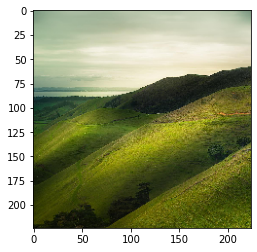

In [7]:
import matplotlib.pyplot as plt

plt.imshow(img)

### 画像の前処理

In [8]:
from tensorflow.keras.applications import resnet

x = image.img_to_array(img)
x = resnet.preprocess_input(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


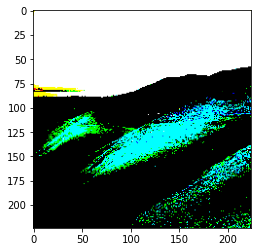

In [9]:
plt.imshow(x)

### 画像の分類

In [10]:
batch_tensor = tf.expand_dims(x, axis=0)
results = model.predict(batch_tensor)
resnet.decode_predictions(results, top=5)

[[('n09468604', 'valley', 0.7663755),
  ('n09246464', 'cliff', 0.069853686),
  ('n11879895', 'rapeseed', 0.05668448),
  ('n09193705', 'alp', 0.043410257),
  ('n03028079', 'church', 0.015742874)]]

00000015.jpgのロード

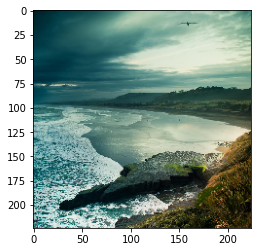

In [11]:
img_path = "/content/landscape-pictures/00000015.jpg"
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)

00000015.jpgの分類結果

In [12]:
x = image.img_to_array(img)
x = resnet.preprocess_input(x)

batch_tensor = tf.expand_dims(x, axis=0)
results = model.predict(batch_tensor)
resnet.decode_predictions(results, top=5)

[[('n09428293', 'seashore', 0.49890733),
  ('n09399592', 'promontory', 0.21681315),
  ('n09246464', 'cliff', 0.1809939),
  ('n09421951', 'sandbar', 0.02358415),
  ('n09468604', 'valley', 0.017773954)]]

## 風景類似画像検索を実装

### 画像ファイルパスを取得

In [13]:
import pathlib
dir_path = "/content/landscape-pictures/"

image_path_list = []
for img_path in pathlib.Path(dir_path).glob("*.jpg"): # ①
    image_path_list.append(img_path)
image_path_list.sort() # ②

### 行列形式へ変換

In [14]:
import numpy as np

images = []
for img_path in image_path_list:
    img = image.load_img(img_path,
                         target_size=(224, 224))
    raw_image = image.img_to_array(img)
    images.append(raw_image)
images = np.array(images)

### ResNetモデルの初期化

In [15]:
from tensorflow.keras.applications import resnet

model = tf.keras.applications.ResNet152(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling="avg",
    classes=1000
    )

### 特徴ベクトルの作成

In [16]:
preprocessed = resnet.preprocess_input(images)
features = model.predict(preprocessed)

### 検索ロジックの作成

In [17]:
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


def get_top_n_indexes(array, num):
    idx = np.argpartition(array, -num)[-num:]
    return idx[np.argsort(array[idx])][::-1]


def search(query_vector, features, num):
    sims = []
    for vector in features:
        sim = cos_sim(query_vector, vector) # ①
        sims.append(sim)
    sims = np.array(sims)
    indexes = get_top_n_indexes(sims, num) # ②
    return indexes, sims[indexes] # ③


### 実際に検索してみる

In [18]:
query_id = 0
results, sims = search(features[query_id], features, 9)

In [19]:
import matplotlib.pyplot as plt

def show_results(results, sims):
    rank = 0
    plt.figure(figsize=(20, 20))

    for idx, sim in zip(results, sims):  # ①
        plt.subplot(3, 3, rank+1)  # ②
        path = image_path_list[idx]
        title = f"rank: {rank}, index: {idx}, sim: {sim:.3f}\n"
        title += f"path: {path}"
        plt.title(title)  # ③
        img = image.load_img(image_path_list[idx],
                            target_size=(224, 224))  # ④
        plt.imshow(img)
        rank += 1

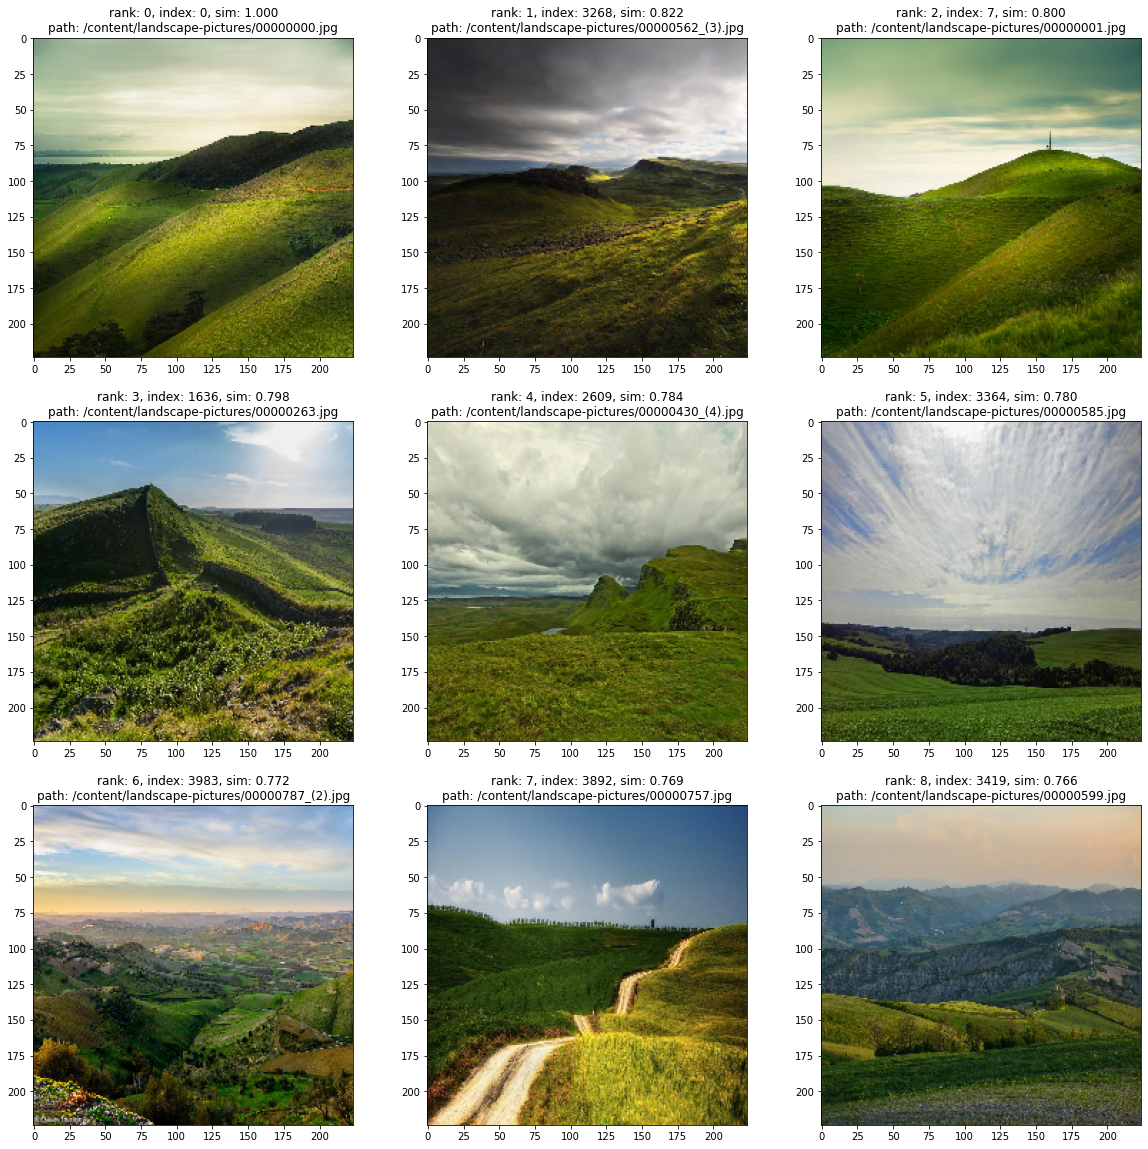

In [20]:
show_results(results, sims)

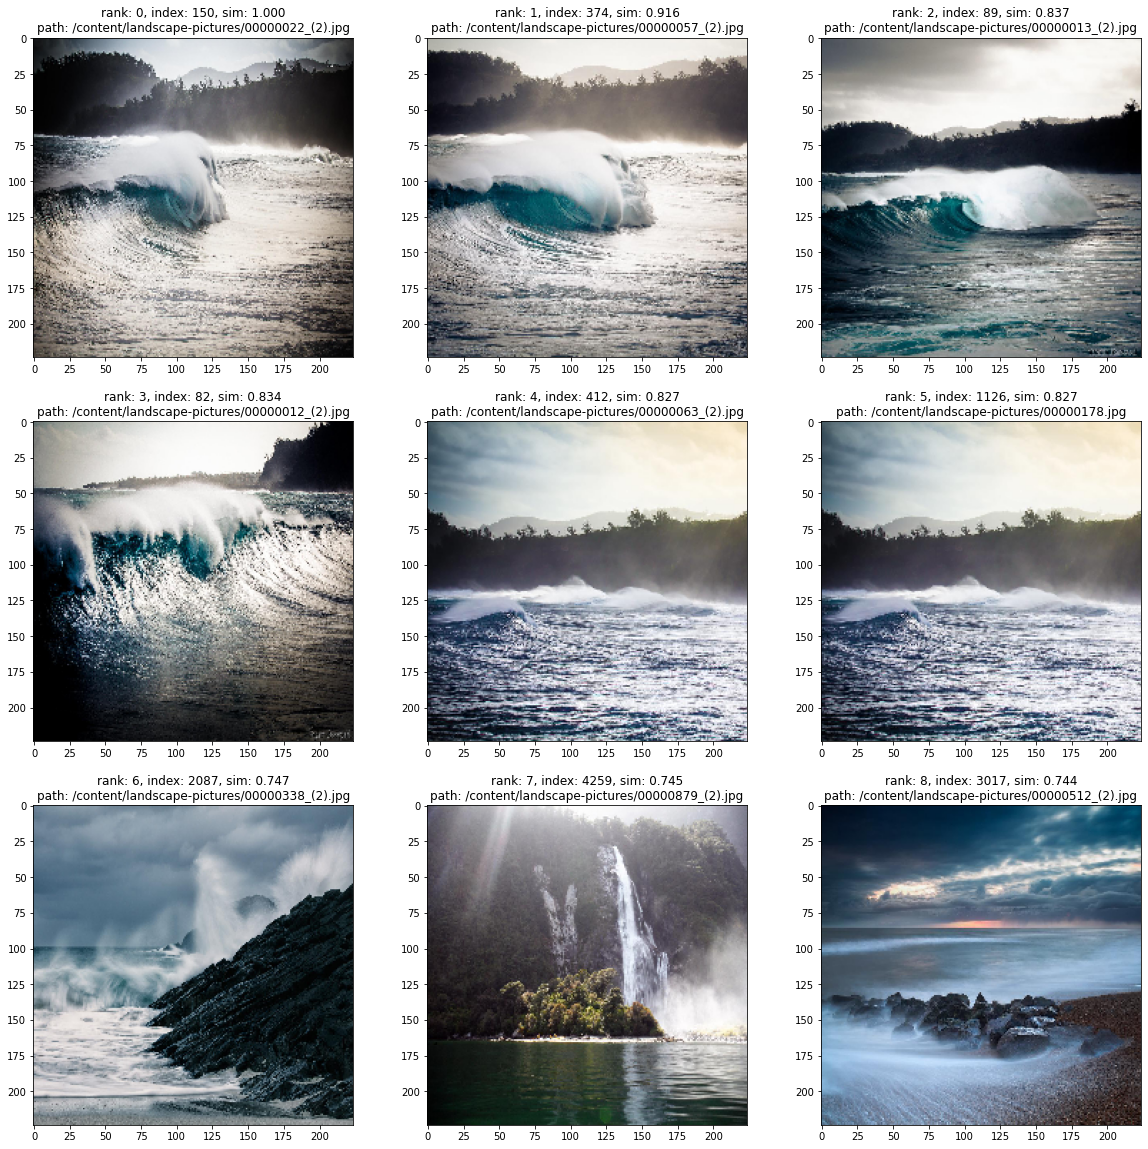

In [21]:
query_id = 150
results, sims = search(features[query_id], features, 9)
show_results(results, sims)

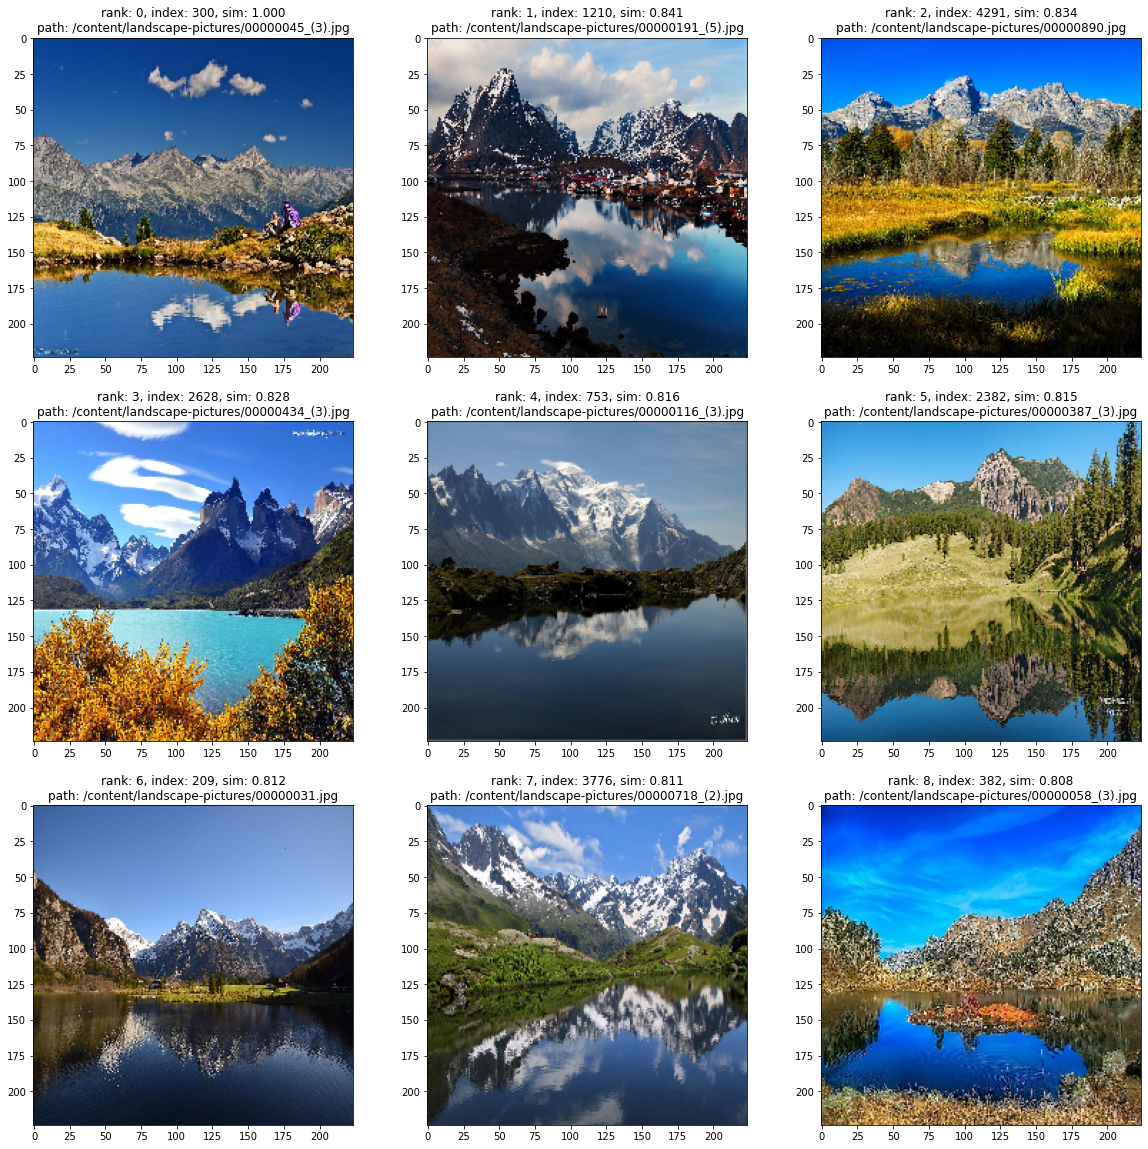

In [22]:
query_id = 300
results, sims = search(features[query_id], features, 9)
show_results(results, sims)

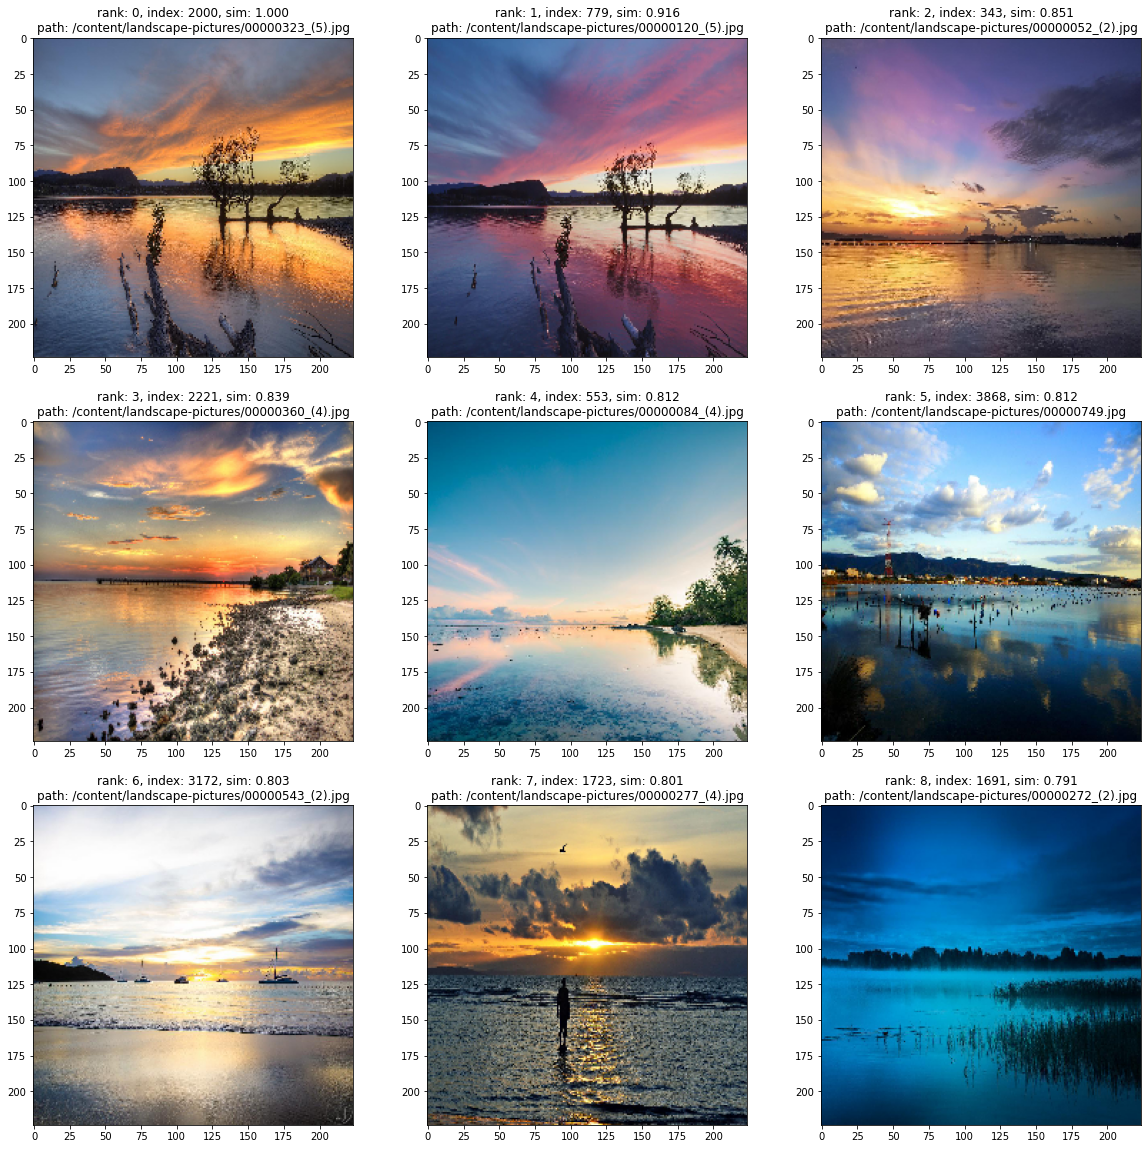

In [23]:
query_id = 2000
results, sims = search(features[query_id], features, 9)
show_results(results, sims)